![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# <a name="0">Machine Learning Accelerator - Tabular Data - Lecture 2</a>

## SageMaker built-in KNN Algorithm 

### Sample Problem: Detecting Products with Electrical Plugs in Amazon Marketplace Products

In this notebook, we use Sagemaker's built-in [KNN](https://docs.aws.amazon.com/sagemaker/latest/dg/k-nearest-neighbors.html) algorithm to predict the __target_label__ field (plug or no plug) of the Amazon electric plug dataset. 


1. <a href="#1">Read the datasets</a>
2. <a href="#2">Data Processing</a>
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Data Preprocessing (cleaning)</a>
    * <a href="#24">Train - Test Datasets</a>
    * <a href="#25">Data processing with Pipeline and ColumnTransformer</a>
3. <a href="#3">Train a Classifier with SageMaker built-in Algorithm</a>
4. <a href="#4">Model evaluation</a>
5. <a href="#5">Deploy the model to an endpoint</a>
6. <a href="#6">Clean up model artifacts</a>


7. <a href="#7">(Optional) Hyperparameter Tuning in SageMaker</a>


__Notes on [AWS SageMaker](https://docs.aws.amazon.com/sagemaker/index.html):__

* Fully managed machine learning service, to quickly and easily get you started on building and training machine learning models - we have seen that already! Integrated Jupyter notebook instances, with easy access to data sources for exploration and analysis, abstract away many of the messy infrastructural details needed for hands-on ML - you don't have to manage servers, install libraries/dependencies, etc.!


* Apart from building custom machine learning models in SageMaker notebooks, like we did so far, SageMaker also provides a few [built-in common machine learning algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) (check "SageMaker Examples" from your SageMaker instance top menu for a complete updated list) that are optimized to run efficiently against extremely large data in a distributed environment. The trained model can then be directly deployed into a production-ready hosted environment for easy access at inference. 


__Dataset schema:__ 
- __ASIN__: Product ASIN
- __target_label:__ Binary field with values in {0,1}. A value of 1 show ASIN has a plug, otherwise 0.
- __ASIN_STATIC_ITEM_NAME:__ Title of the ASIN.
- __ASIN_STATIC_PRODUCT_DESCRIPTION:__ Description of the ASIN
- __ASIN_STATIC_GL_PRODUCT_GROUP_TYPE:__ GL information for the ASIN.
- __ASIN_STATIC_ITEM_PACKAGE_WEIGHT:__ Weight of the ASIN.
- __ASIN_STATIC_LIST_PRICE:__ Price information for the ASIN.
- __ASIN_STATIC_BATTERIES_INCLUDED:__ Information whether batteries are included along with the product.
- __ASIN_STATIC_BATTERIES_REQUIRED:__ Information whether batteries are required for using the product.
- __ASIN_STATIC_ITEM_CLASSIFICATION:__ Item classification of whether it is a standalone or bundle parent item etc


## 1. <a name="1">Read the datasets</a>
(<a href="#0">Go to top</a>)

Let's read the training and test data files into dataframes, using [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html).

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
  
df = pd.read_csv('../../data/review/asin_electrical_plug_training_data.csv')
test_data = pd.read_csv('../../data/review/asin_electrical_plug_test_data.csv')

print('The shape of the training dataset is:', df.shape)
print('The shape of the test dataset is:', test_data.shape)

The shape of the training dataset is: (55109, 10)
The shape of the test dataset is: (6124, 10)


## 2. <a name="2">Data Processing</a>
(<a href="#0">Go to top</a>)

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the training dataset.

In [2]:
# Print the first five rows
# NaN means missing data
df.head()

,ASIN,target_label,ASIN_STATIC_ITEM_NAME,ASIN_STATIC_PRODUCT_DESCRIPTION,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE,ASIN_STATIC_BATTERIES_INCLUDED,ASIN_STATIC_BATTERIES_REQUIRED,ASIN_STATIC_ITEM_CLASSIFICATION
0,B000816IUC,0,Bruder 02921 Jeep Wrangler Unlimited with Hors...,NEW! Jeep Wrangler by Bruder with trailer come...,gl_toy,3.450000,36.66,False,False,base_product
1,B003674A1Y,0,"Lucky Reptile OV-2 OpenAir Vivarium, Medium",Größe: 40x40x60 cm. <p>Lucky Reptile OpenAir V...,gl_pet_products,2.690000,24.68,False,False,base_product
2,B007ECONV4,0,"Klarfit KS5DG Chin Up Bar (150kg Max Load, Doo...",<p><b>Highly flexible pull-up bar with six con...,gl_sports,8.112928,NaN,False,False,base_product
3,B00D89465A,0,Liverpool FC Stripe Wallpaper,This fantastic Liverpool Wallpaper is ideal fo...,gl_home,1.763680,8.33,NaN,NaN,base_product
4,B001MJ0BN4,0,Rolson 68889 Oil Tanned Double Tool Pouch,"Eleven pockets, two fixed metal hammer holders...",gl_biss,2.733704,27.38,NaN,NaN,base_product


In [3]:
print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (55109, 10)


In [4]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55109 entries, 0 to 55108
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ASIN                               55109 non-null  object 
 1   target_label                       55109 non-null  int64  
 2   ASIN_STATIC_ITEM_NAME              55109 non-null  object 
 3   ASIN_STATIC_PRODUCT_DESCRIPTION    31727 non-null  object 
 4   ASIN_STATIC_GL_PRODUCT_GROUP_TYPE  55109 non-null  object 
 5   ASIN_STATIC_ITEM_PACKAGE_WEIGHT    55027 non-null  float64
 6   ASIN_STATIC_LIST_PRICE             41182 non-null  float64
 7   ASIN_STATIC_BATTERIES_INCLUDED     45016 non-null  object 
 8   ASIN_STATIC_BATTERIES_REQUIRED     40688 non-null  object 
 9   ASIN_STATIC_ITEM_CLASSIFICATION    55097 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 4.6+ MB


In [5]:
# This will print basic statistics for numerical columns
df.describe()

,target_label,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE
count,55109.000000,55027.000000,4.118200e+04
mean,0.036618,31.130529,1.563334e+02
std,0.187825,458.771422,1.754345e+04
min,0.000000,0.000000,1.160000e+00
25%,0.000000,1.520000,1.667000e+01
50%,0.000000,2.513244,3.268500e+01
75%,0.000000,5.555592,6.999000e+01
max,1.000000,29500.000000,3.560000e+06


#### Target distribution

Let's check our target distribution.

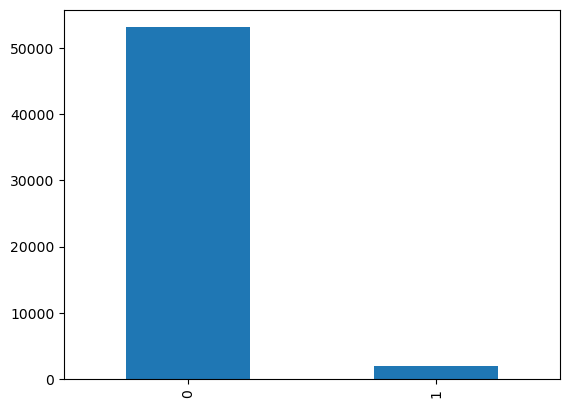

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

df['target_label'].value_counts().plot.bar()
plt.show()

We notice that we are dealing with an imbalanced dataset. This means one result type is dominating the other one(s). In this case, we have a lot of class 0 ("no plug") records and very few class 1 ("plug") records. 

#### Dataset features

Let's now print the features of our dataset.

In [7]:
import numpy as np                    
# use this for datasets with more columns, to print all columns
# (beware, if might raise memory errors when trying to print the text features values!)
# np.set_printoptions(threshold=np.inf) 

# This prints the column labels of the dataframe
print('All dataset columns:')
print(df.columns.values)

# This prints the column labels of the features identified as numerical
print('Numerical columns:')
print(df.select_dtypes(include=np.number).columns.values)

# This prints the column labels of the features identified as numerical
print('Categorical columns:')
print(df.select_dtypes(include='object').columns.values)

All dataset columns:
['ASIN' 'target_label' 'ASIN_STATIC_ITEM_NAME'
 'ASIN_STATIC_PRODUCT_DESCRIPTION' 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE'
 'ASIN_STATIC_ITEM_PACKAGE_WEIGHT' 'ASIN_STATIC_LIST_PRICE'
 'ASIN_STATIC_BATTERIES_INCLUDED' 'ASIN_STATIC_BATTERIES_REQUIRED'
 'ASIN_STATIC_ITEM_CLASSIFICATION']
Numerical columns:
['target_label' 'ASIN_STATIC_ITEM_PACKAGE_WEIGHT' 'ASIN_STATIC_LIST_PRICE']
Categorical columns:
['ASIN' 'ASIN_STATIC_ITEM_NAME' 'ASIN_STATIC_PRODUCT_DESCRIPTION'
 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE' 'ASIN_STATIC_BATTERIES_INCLUDED'
 'ASIN_STATIC_BATTERIES_REQUIRED' 'ASIN_STATIC_ITEM_CLASSIFICATION']


### 2.2 <a name="22">Select features to build the model</a>
(<a href="#2">Go to Data Processing</a>)

We build a model using all features (except __ASIN__). That is, we build a classifier including __numerical, categorical__ and __text__ features. 

In [8]:
# Grab model features/inputs and target/output
numerical_features = ["ASIN_STATIC_ITEM_PACKAGE_WEIGHT",
                      "ASIN_STATIC_LIST_PRICE"]

categorical_features = ['ASIN_STATIC_GL_PRODUCT_GROUP_TYPE',
               'ASIN_STATIC_BATTERIES_INCLUDED',
               'ASIN_STATIC_BATTERIES_REQUIRED',
               'ASIN_STATIC_ITEM_CLASSIFICATION']

text_features = ['ASIN_STATIC_ITEM_NAME',
                 'ASIN_STATIC_PRODUCT_DESCRIPTION']

model_features = numerical_features + categorical_features + text_features
model_target = 'target_label'


### 2.3 <a name="23">Data Preprocessing (Cleaning)</a>
(<a href="#2">Go to Data Processing</a>)

Before data processing, we first clean the dataset.


### Cleaning numerical features 

Let's examine the numerical features.

In [9]:
for c in numerical_features:
    print(c)
    print(df[c].value_counts(bins=10, sort=False))

ASIN_STATIC_ITEM_PACKAGE_WEIGHT
(-29.501, 2950.0]     54910
(2950.0, 5900.0]         50
(5900.0, 8850.0]         28
(8850.0, 11800.0]        19
(11800.0, 14750.0]        8
(14750.0, 17700.0]        7
(17700.0, 20650.0]        1
(20650.0, 23600.0]        0
(23600.0, 26550.0]        1
(26550.0, 29500.0]        3
Name: ASIN_STATIC_ITEM_PACKAGE_WEIGHT, dtype: int64
ASIN_STATIC_LIST_PRICE
(-3558.84, 356001.044]        41181
(356001.044, 712000.928]          0
(712000.928, 1068000.812]         0
(1068000.812, 1424000.696]        0
(1424000.696, 1780000.58]         0
(1780000.58, 2136000.464]         0
(2136000.464, 2492000.348]        0
(2492000.348, 2848000.232]        0
(2848000.232, 3204000.116]        0
(3204000.116, 3560000.0]          1
Name: ASIN_STATIC_LIST_PRICE, dtype: int64


__Outliers__. We have an outlier data in the last bin of the second numerical feature. We will remove this data point below.

In [10]:
#print(df[df[numerical_features[1]] > 3000000])
dropIndexes = df[df[numerical_features[1]] > 3000000].index
df.drop(dropIndexes , inplace=True)

In [11]:
print(df[numerical_features[1]].value_counts(bins=10, sort=False))

(-13.838999999999999, 1500.944]    41147
(1500.944, 3000.728]                  15
(3000.728, 4500.512]                   8
(4500.512, 6000.296]                   3
(6000.296, 7500.08]                    2
(7500.08, 8999.864]                    3
(8999.864, 10499.648]                  0
(10499.648, 11999.432]                 1
(11999.432, 13499.216]                 0
(13499.216, 14999.0]                   2
Name: ASIN_STATIC_LIST_PRICE, dtype: int64


__Missing Numerical Values__. Let's check missing values for these numerical features.

In [12]:
print(df[numerical_features].isna().sum())

ASIN_STATIC_ITEM_PACKAGE_WEIGHT       82
ASIN_STATIC_LIST_PRICE             13927
dtype: int64


As a quick fix, we will apply mean imputation. This will replace the missing values with the mean value of the corresponding column.

__Note on imputation__: The statistically correct way to perform mean/mode imputation before training an ML model is to compute the column-wise means on the training data only, and then use these values to impute missing data in the train, validation, and test sets. So, we'll need to split our training dataset first. Same goes for any other transformations we would like to apply to these numerical features, such as scaling or encoding. 

### Cleaning categorical features 

Let's also examine the categorical features.

In [13]:
for c in categorical_features:
    print(c)
    print(df[c].unique()) #value_counts())

ASIN_STATIC_GL_PRODUCT_GROUP_TYPE
['gl_toy' 'gl_pet_products' 'gl_sports' 'gl_home' 'gl_biss'
 'gl_home_improvement' 'gl_baby_product' 'gl_office_product'
 'gl_lawn_and_garden' 'gl_musical_instruments' 'gl_camera' 'gl_kitchen'
 'gl_automotive' 'gl_electronics' 'gl_personal_care_appliances' 'gl_pc'
 'gl_drugstore' 'gl_luggage' 'gl_wireless' 'gl_home_entertainment'
 'gl_major_appliances' 'gl_apparel' 'gl_beauty' 'gl_shoes' 'gl_watch'
 'gl_video_games' 'gl_book' 'gl_music' 'gl_fresh_ambient']
ASIN_STATIC_BATTERIES_INCLUDED
[False nan True]
ASIN_STATIC_BATTERIES_REQUIRED
[False nan True]
ASIN_STATIC_ITEM_CLASSIFICATION
['base_product' nan 'variation_parent']


__Note on boolean type__: Most categories are strings, except the __nan__s, and the booleans __False__ and __True__. The booleans will raise errors when trying to encode the categoricals with sklearn encoders, none of which accept boolean types. If using pandas get_dummies to one-hot encode the categoricals, there's no need to convert the booleans. However, get_dummies is trickier to use with sklearn's Pipeline and GridSearch. 

One way to deal with the booleans is to convert them to strings, by using a mask and a map changing only the booleans.

In [14]:
# Converting booleans to strings for a dataframe
def convert_bool_to_str(dataframe):
    mask = dataframe.applymap(type) != bool
    do = {True: 'TRUE', False: 'FALSE'}
    return dataframe.where(mask, dataframe.replace(do))

In [15]:
# Convert booleans to strings for training and test datasets
df_masked = convert_bool_to_str(df)
test_data_masked = convert_bool_to_str(test_data)

In [16]:
for c in categorical_features:
    print(c)
    print(df_masked[c].unique()) #value_counts())

ASIN_STATIC_GL_PRODUCT_GROUP_TYPE
['gl_toy' 'gl_pet_products' 'gl_sports' 'gl_home' 'gl_biss'
 'gl_home_improvement' 'gl_baby_product' 'gl_office_product'
 'gl_lawn_and_garden' 'gl_musical_instruments' 'gl_camera' 'gl_kitchen'
 'gl_automotive' 'gl_electronics' 'gl_personal_care_appliances' 'gl_pc'
 'gl_drugstore' 'gl_luggage' 'gl_wireless' 'gl_home_entertainment'
 'gl_major_appliances' 'gl_apparel' 'gl_beauty' 'gl_shoes' 'gl_watch'
 'gl_video_games' 'gl_book' 'gl_music' 'gl_fresh_ambient']
ASIN_STATIC_BATTERIES_INCLUDED
['FALSE' nan 'TRUE']
ASIN_STATIC_BATTERIES_REQUIRED
['FALSE' nan 'TRUE']
ASIN_STATIC_ITEM_CLASSIFICATION
['base_product' nan 'variation_parent']


Another way to handle the booleans is to convert them to strings by changing the type of all categoricals to 'str'. This will also affect the nans, basically performing imputation of the nans with a 'nans' placeholder value! 

Applying the type conversion to both categoricals and text features, takes care of the nans in the text fields as well. In case other imputations are planned for the categoricals and/or test fields, notice that the masking shown above leaves the nans unchanged.

In [17]:
# Perform boolean to string operation on training and test datasets
df[categorical_features + text_features] = df[categorical_features + text_features].astype('str')
test_data[categorical_features + text_features] = test_data[categorical_features + text_features].astype('str')

In [18]:
for c in categorical_features:
    print(c)
    print(df[c].unique()) #value_counts())

ASIN_STATIC_GL_PRODUCT_GROUP_TYPE
['gl_toy' 'gl_pet_products' 'gl_sports' 'gl_home' 'gl_biss'
 'gl_home_improvement' 'gl_baby_product' 'gl_office_product'
 'gl_lawn_and_garden' 'gl_musical_instruments' 'gl_camera' 'gl_kitchen'
 'gl_automotive' 'gl_electronics' 'gl_personal_care_appliances' 'gl_pc'
 'gl_drugstore' 'gl_luggage' 'gl_wireless' 'gl_home_entertainment'
 'gl_major_appliances' 'gl_apparel' 'gl_beauty' 'gl_shoes' 'gl_watch'
 'gl_video_games' 'gl_book' 'gl_music' 'gl_fresh_ambient']
ASIN_STATIC_BATTERIES_INCLUDED
['False' 'nan' 'True']
ASIN_STATIC_BATTERIES_REQUIRED
['False' 'nan' 'True']
ASIN_STATIC_ITEM_CLASSIFICATION
['base_product' 'nan' 'variation_parent']


Converting categoricals into useful numerical features, will also have to wait until after the train/test split.

### Cleaning text features 

Also a good idea to look at the text fields. Text cleaning can be performed here, before train/test split, with less code.

In [19]:
#for c in text_features:
#    print(c)
#    print(df[c].unique()) #value_counts())

We re-use the helper functions from the 'Text processing' notebook.

In [20]:
# Prepare cleaning functions
import re, string
import nltk
from nltk.stem import SnowballStemmer

stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer('english')

def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()
    
    # remove HTML tags
    text = re.compile('<.*?>').sub('', text)
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove extra white space
    text = re.sub('\s+', ' ', text)
    
    return text

def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)
    
    return text

def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)



__Warning__: The text cleaning process can take a long time to complete, depending on the size of the text data!

In [21]:
# Clean the text features
for c in text_features:
    print('Text cleaning: ', c)
    df[c] = [cleanSentence(item, stop_words, stemmer) for item in df[c].values]
    test_data[c] = [cleanSentence(item, stop_words, stemmer) for item in test_data[c].values]

Text cleaning:  ASIN_STATIC_ITEM_NAME
Text cleaning:  ASIN_STATIC_PRODUCT_DESCRIPTION


The cleaned text features of the training and test dataset are ready to be vectorized.

### 2.4 <a name="24">Train - Test Datasets</a>
(<a href="#2">Go to Data Processing</a>)

We have already split the original dataset into two data files: __training__ data file (asin_electrical_plug_training_data.csv) with __90%__ of the samples and the __test__ data file (asin_electrical_plug_test_data.csv) with the remaining __10%__. 
Such splits can be performed using sklearn's [__train_test_split()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [22]:
# Set the training data as our df
train_data = df

# Print the shapes of the Train - Test Datasets
print('Train - Test Datasets shapes: ', train_data.shape, test_data.shape)

Train - Test Datasets shapes:  (55108, 10) (6124, 10)


### 2.5 <a name="25">Data processing with Pipeline and ColumnTransformer</a>
(<a href="#2">Go to Data Processing</a>)

We use the collective __ColumnTransformer__ to preprocess the data for SageMaker model training and test, ensuring that the transformations learned on the train data are performed accordingly on the training and test datasets.

In [23]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('num_scaler', MinMaxScaler()) # Shown in case is needed, not a must with Decision Trees
                                ])
                  
# Preprocess the categorical features
categorical_processor = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Shown in case is needed, no effect here as we already imputed with 'nan' strings
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')) # handle_unknown tells it to ignore (rather than throw an error for) any value that was not present in the initial training set.
                                ])

# Preprocess 1st text feature
text_processor_0 = Pipeline([
    ('text_vectorizer_0', CountVectorizer(binary=True, max_features=50))
                                ])

# Preprocess 2nd text feature (larger vocabulary)
text_processor_1 = Pipeline([
    ('text_vectorizer_1', CountVectorizer(binary=True, max_features=150))
                                ])

# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_processor = ColumnTransformer([
    ('numerical_processing', numerical_processor, numerical_features),
    ('categorical_processing', categorical_processor, categorical_features),
    ('text_processing_0', text_processor_0, text_features[0]),
    ('text_processing_1', text_processor_1, text_features[1])
                                    ]) 

# Visualize the data processing pipeline
from sklearn import set_config
set_config(display='diagram')
data_processor

### DATA PROCESSING ###
#######################

# Get train data to train the network
X_train = train_data[model_features]
y_train = train_data[model_target]

# Get test data to test the network for submission to the leaderboard
X_test = test_data[model_features]
y_test = test_data[model_target]

print('Datasets shapes before processing: ', X_train.shape, X_test.shape)

X_train = data_processor.fit_transform(X_train).toarray()
X_test = data_processor.transform(X_test).toarray()

print('Datasets shapes after processing: ', X_train.shape, X_test.shape)


Datasets shapes before processing:  (55108, 8) (6124, 8)
Datasets shapes after processing:  (55108, 240) (6124, 240)


## 3. <a name="3">Train a classifier with SageMaker built-in algorithm</a>
(<a href="#0">Go to top</a>)

We use Amazon SageMaker [KNN](https://docs.aws.amazon.com/sagemaker/latest/dg/k-nearest-neighbors.html) algorithm to build our classifier. We explain the components common to all Amazon SageMaker's algorithms including uploading data to Amazon S3, training a model, and setting up an endpoint for online inference. 

### Set up the SageMaker environment

Let's start by importing libraries we need.


In [24]:
import boto3
from os import path
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

### Upload datasets to Amazon S3

Amazon SageMaker [K-Nearest Neighbors (k-NN)](https://docs.aws.amazon.com/sagemaker/latest/dg/k-nearest-neighbors.html) can train on data in either a CSV or recordIO-wrapped-protobuf format.  For this example, we stick with the recordIO-wrapped-protobuf.  

So, let's write the data to Amazon S3 in recordio-protobuf format. We first create an io buffer wrapping the data, next we upload it to Amazon S3. Notice that the choice of bucket and prefix should change for different users and different datasets.

In [25]:
import io
import sagemaker.amazon.common as smac

print('train_features shape = ', X_train.shape)
print('train_labels shape = ', y_train.shape)

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train, y_train.values)
buf.seek(0)

train_features shape =  (55108, 240)
train_labels shape =  (55108,)


0

In [26]:
import os
import boto3
import sagemaker

bucket = sagemaker.Session().default_bucket()
prefix = 'knn-demo'
key = 'recordio-pb-data'

boto3.resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'train', key)).upload_fileobj(buf)

s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)

print('uploaded training data location: {}'.format(s3_train_data))
 

uploaded training data location: s3://sagemaker-us-west-2-835188026949/knn-demo/train/recordio-pb-data


It is also possible to provide test data. This way we can get an test of the performance of the model from the training logs. In order to use this capability let's upload the test data to Amazon S3 as well.

In [27]:
print('test_features shape = ', X_test.shape)
print('test_labels shape = ', y_test.shape)

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_test, y_test.values)
buf.seek(0)
    
boto3.resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'test', key)).upload_fileobj(buf)

s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)

print('uploaded test data location: {}'.format(s3_test_data))
 

test_features shape =  (6124, 240)
test_labels shape =  (6124,)
uploaded test data location: s3://sagemaker-us-west-2-835188026949/knn-demo/test/recordio-pb-data


### Fitting the classifier

We use the built-in Sagemaker [K-Nearest Neighbors (k-NN)](https://docs.aws.amazon.com/sagemaker/latest/dg/k-nearest-neighbors.html) below. 

In Amazon SageMaker, model training is done via an object called an __estimator__. When setting up the estimator we specify the location (in Amazon S3) of the training data, the path (again in Amazon S3) to the output directory where the model will be serialized, generic hyper-parameters such as the machine type to use during the training process, and kNN-specific hyper-parameters. Once the estimator is initialized, we can call its __.fit()__ method in order to do the actual training.

* __Compute power:__ We will use `train_instance_count` and `train_instance_type` parameters. This example uses `ml.m4.xlarge` resource for training. The instance_type is the machine type that will host the model. We can change the instance type for our needs (for example GPUs for neural networks).
* __Model type:__ `predictor_type` is set to __`classifier`__, as we have a classification problem here.
* __Hyperparameters:__ For now, we stick to default required parameters __`predictor_type`__, __`feature_dim`__, __`k`__, and __`sample_size`__. The __`sample_size`__ parameter determines how many points from the data set should be used for building the model. Using all the data points is tempting and definitely can't hurt the quality of the outputs but is often either infeasible or simply too costly. Moreover, it can often be unnecessary in the sense that you may get the same accuracy with less points. In that case, there is simply no need to build a model with all the data points. In this example we use a sample of 10K points out of the potential ~48K in the training set.

In [28]:
# set an output path where the trained model will be saved
output_path = 's3://{}/{}/output'.format(bucket, prefix)

# set required KNN hyperparameters
hyperparams = {
    'predictor_type': 'classifier', 
    'feature_dim': 240,
    'k': 10,
    'sample_size': 10000
                }

region = boto3.Session().region_name

# Create a container with KNN
container = sagemaker.image_uris.retrieve('knn', region)

# Call the KNN estimator object
KNN_estimator = sagemaker.estimator.Estimator(
        container,
        get_execution_role(),
        hyperparameters = hyperparams,
        instance_count=1,
        instance_type='ml.m5.2xlarge',
        output_path=output_path,
        sagemaker_session=sagemaker.Session())


Now, we run the actual training job. 

__Warning: This process takes about 3-4 minutes to complete on the ml.m4.xlarge instance.__

In [29]:
%%time
KNN_estimator.fit({'train': s3_train_data, 'test': s3_test_data})

INFO:sagemaker:Creating training-job with name: knn-2023-06-09-18-11-54-676


2023-06-09 18:11:54 Starting - Starting the training job...
2023-06-09 18:12:18 Starting - Preparing the instances for training......
2023-06-09 18:13:13 Downloading - Downloading input data...
2023-06-09 18:13:33 Training - Downloading the training image......
2023-06-09 18:14:49 Training - Training image download completed. Training in progress....
2023-06-09 18:15:25 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[06/09/2023 18:15:14 INFO 139755190437696] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'_kvstore': 'dist_async', '_log_level': 'info', '_num_gpus': 'auto', '_num_kv_servers': '1', '_tuning_objective_metric': '', '_faiss_index_nprobe': '5', 'epochs': '1', 'feature_dim': 'auto', 'faiss_index_ivf_nlists': 'auto', 'index_metric': 'L2', 'index_type': 'faiss.Flat', 'mini_batch_size': '5000', '_enable_profiler': 'fa


2023-06-09 18:15:36 Completed - Training job completed
Training seconds: 143
Billable seconds: 143
CPU times: user 854 ms, sys: 35.6 ms, total: 890 ms
Wall time: 4min 16s


## 4. <a name="4">Model Evaluation</a>
(<a href="#0">Go to top</a>)

We can use Sagemaker analytics to get the performance metric on the test set. This doesn't require us to deploy our model. AWS SageMaker [KNN](https://docs.aws.amazon.com/sagemaker/latest/dg/k-nearest-neighbors.html) computes __`test:accuracy`__ for a classification task. 


In [30]:
sagemaker.analytics.TrainingJobAnalytics(KNN_estimator._current_job_name, 
                                         metric_names = ['test:accuracy']
                                        ).dataframe()

,timestamp,metric_name,value
0,0.0,test:accuracy,0.963096


## 5. <a name="5">Deploy the model to an endpoint</a>
(<a href="#0">Go to top</a>)


We have successfully trained and evaluated our model. If happy with the performance, it is time to deploy the model to another instance of our choice. We set up what is called an __endpoint__. An endpoint is a web service that given a request containing an unlabeled data point, or mini-batch of data points, returns a prediction(s). This allow us to use this model in production environment. 

Deployed endpoints can be used with other AWS Services such as Lambda and API Gateway. A nice walkthrough is available here: https://aws.amazon.com/blogs/machine-learning/call-an-amazon-sagemaker-model-endpoint-using-amazon-api-gateway-and-aws-lambda/ if you are interested.

We use a `ml.t2.medium` instance here, but can also use other instance types such as:, `ml.c4.xlarge` etc. 

__Warning: This process takes about 10-11 minutes to complete.__

In [31]:
%%time
KNN_predictor = KNN_estimator.deploy(initial_instance_count=1, 
                                     instance_type="ml.t2.medium", 
                                     endpoint_name="endpoint-mla-tab-2023June9-knn") # endpoint_name needs to be unique!

INFO:sagemaker:Creating model with name: knn-2023-06-09-18-16-11-221
INFO:sagemaker:Creating endpoint-config with name endpoint-mla-tab-2023June9-knn
INFO:sagemaker:Creating endpoint with name endpoint-mla-tab-2023June9-knn


--------------------------!CPU times: user 260 ms, sys: 17 ms, total: 277 ms
Wall time: 13min 34s


## 6. <a name="6">Clean up model artifacts</a>
(<a href="#0">Go to top</a>)

__If you're ready to be done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.__

In [32]:
KNN_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: endpoint-mla-tab-2023June9-knn
INFO:sagemaker:Deleting endpoint with name: endpoint-mla-tab-2023June9-knn


## 7. <a name="7">(Optional) Hyperparameter Tuning in SageMaker with the Python SDK</a>
(<a href="#0">Go to top</a>)

Automatic model tuning, finds the best version of a model by running many jobs that test a range of hyperparameters on your dataset. We choose the tunable hyperparameters, a range of values for each, and an objective metric. Objective metrics are chosen from the metrics that the algorithm computes. AWS SageMaker [KNN](https://docs.aws.amazon.com/sagemaker/latest/dg/k-nearest-neighbors.html) computes __`test:accuracy`__ for a classification task. 

We tune AWS SageMaker [KNN](https://docs.aws.amazon.com/sagemaker/latest/dg/kNN-tuning.html) with the following hyperparameters: __`k`__ and __`sample_size`__. 


In [33]:
# Recreate the Estimator from above

# set an output path where the trained model will be saved
output_path = 's3://{}/{}/output'.format(bucket, prefix)

# set required KNN hyperparameters
hyperparams = {
    'predictor_type': 'classifier', 
    'feature_dim': 240,
    'k': 10,
    'sample_size': 10000
                }

region = boto3.Session().region_name

# Call the KNN estimator object
KNN_estimator = sagemaker.estimator.Estimator(
        sagemaker.image_uris.retrieve('knn', region),
        get_execution_role(),
        hyperparameters = hyperparams,
        instance_count=1,
        instance_type='ml.m5.2xlarge',
        output_path=output_path,
        sagemaker_session=sagemaker.Session())


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


We can specify the hyperparameters we'd like to tune and their possible values. We have three different types of hyperparameters.
   * __Categorical parameters__ need to take one value from a discrete set. We define this by passing the list of possible values to CategoricalParameter(list)
   * __Continuous parameters__ can take any real number value between the minimum and maximum value, defined by ContinuousParameter(min, max)
   * __Integer parameters__ can take any integer value between the minimum and maximum value, defined by IntegerParameter(min, max)

*Note, if possible, it's almost always best to specify a value as the least restrictive type. For example, tuning threshold as a continuous value between 0.01 and 0.2 is likely to yield a better result than tuning as a categorical parameter with possible values of 0.01, 0.1, 0.15, or 0.2.* 

In [34]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter

# Define exploration boundaries
hyperparameter_ranges = {
                        'k': IntegerParameter(1, 10),
                        'sample_size': IntegerParameter(2560, 10000)
                        }


Now, we'll create a __HyperparameterTuner__ object, to which we pass:

* The __estimator__ we created above
* Our __hyperparameter ranges__ 
* __objective metric name__, that is the objective metric that we'd like to tune
* __objective type__: whether we should maximize or minimize our objective metric (we haven't specified here since it defaults to 'Maximize', which is what we want for test accuracy)
* __max_jobs__: number of training jobs to run in total
* __max_parallel_jobs__: how many training jobs should be run simultaneously


In [35]:
from sagemaker.tuner import HyperparameterTuner

# create tuner
KNN_tuner = HyperparameterTuner(estimator=KNN_estimator,
                            objective_metric_name='test:accuracy',
                            hyperparameter_ranges=hyperparameter_ranges,
                            objective_type='Maximize',
                            max_jobs=9,
                            max_parallel_jobs=3)


And finally, we can start our tuning job by calling __.fit()__ and passing in the S3 paths to our train and test datasets.

__Warning: This this step may take 13-14 minutes to complete.__ Even if you loose connection with the notebook in the middle, as long as the notebook instance continues to run, jobs should still be successfully created for future use.

In [36]:
%%time
KNN_tuner.fit({'train': s3_train_data, 'test': s3_test_data})
KNN_tuner.wait()

INFO:sagemaker:Creating hyperparameter tuning job with name: knn-230609-1829


..................................................................................!
!
CPU times: user 413 ms, sys: 39.9 ms, total: 453 ms
Wall time: 7min 11s


Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully and is `InProgress`.

In [37]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=KNN_tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

__Note__: You will be unable to successfully run the following cells until the tuning job completes. 

In [38]:
# get tuner results in a dataframe
results = KNN_tuner.analytics().dataframe()
print(results.head(20))

      k  sample_size               TrainingJobName TrainingJobStatus  \
0   7.0       9788.0  knn-230609-1829-009-04394ea8         Completed   
1   6.0       7278.0  knn-230609-1829-008-6212a6c0         Completed   
2   5.0       6002.0  knn-230609-1829-007-1ade3091         Completed   
3   9.0       8388.0  knn-230609-1829-006-7338c7f4         Completed   
4  10.0       9448.0  knn-230609-1829-005-76c7857c         Completed   
5   1.0       7323.0  knn-230609-1829-004-db825a9b         Completed   
6   8.0       6980.0  knn-230609-1829-003-88f0c586         Completed   
7   4.0       8614.0  knn-230609-1829-002-e64bd444         Completed   
8  10.0       6702.0  knn-230609-1829-001-6c106582         Completed   

   FinalObjectiveValue         TrainingStartTime           TrainingEndTime  \
0             0.962116 2023-06-09 18:36:18+00:00 2023-06-09 18:36:50+00:00   
1             0.962443 2023-06-09 18:36:11+00:00 2023-06-09 18:36:43+00:00   
2             0.958361 2023-06-09 18:36:09+00

Once the tuning job finishes, we can bring in a table of metrics.

In [39]:
bayes_metrics = sagemaker.HyperparameterTuningJobAnalytics(KNN_tuner._current_job_name).dataframe()
bayes_metrics.sort_values(['FinalObjectiveValue'], ascending=False)

,k,sample_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
6,8.0,6980.0,knn-230609-1829-003-88f0c586,Completed,0.962933,2023-06-09 18:31:17+00:00,2023-06-09 18:34:55+00:00,218.0
8,10.0,6702.0,knn-230609-1829-001-6c106582,Completed,0.962933,2023-06-09 18:31:01+00:00,2023-06-09 18:34:54+00:00,233.0
3,9.0,8388.0,knn-230609-1829-006-7338c7f4,Completed,0.962769,2023-06-09 18:35:21+00:00,2023-06-09 18:35:52+00:00,31.0
4,10.0,9448.0,knn-230609-1829-005-76c7857c,Completed,0.962769,2023-06-09 18:35:23+00:00,2023-06-09 18:35:55+00:00,32.0
1,6.0,7278.0,knn-230609-1829-008-6212a6c0,Completed,0.962443,2023-06-09 18:36:11+00:00,2023-06-09 18:36:43+00:00,32.0
7,4.0,8614.0,knn-230609-1829-002-e64bd444,Completed,0.962443,2023-06-09 18:31:06+00:00,2023-06-09 18:34:54+00:00,228.0
0,7.0,9788.0,knn-230609-1829-009-04394ea8,Completed,0.962116,2023-06-09 18:36:18+00:00,2023-06-09 18:36:50+00:00,32.0
2,5.0,6002.0,knn-230609-1829-007-1ade3091,Completed,0.958361,2023-06-09 18:36:09+00:00,2023-06-09 18:36:40+00:00,31.0
5,1.0,7323.0,knn-230609-1829-004-db825a9b,Completed,0.927825,2023-06-09 18:35:21+00:00,2023-06-09 18:35:52+00:00,31.0


Analyzing the tuning results, we can pick an optimal parameter combination to build a final model that we can deploy for inference, or we can use the optimal paramater combination as a first round of tuning parameters to inform a secondary round of hyperparamater tuning where ranges could be narrowed down further.   

For more information about automatic model tuning, see [Automatic Model Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html). In particular for hyperparameter tuning of Amazon SageMaker KNN's built-in algoritm see "Part 2: Deep dive, Tuning KNN" of the kNN notebook sample under "SageMaker Examples" from your SageMaker instance top menu - next to 'Files', 'Running', 'Clusters'.